# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [36]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [37]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("MAPBOX_API_KEY")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [38]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")
sfo_data.head()

,neighborhood,sale_price_sqr_foot,housing_units,gross_rent
year,,,,
2010,Alamo Square,291.182945,372560,1239
2010,Anza Vista,267.932583,372560,1239
2010,Bayview,170.098665,372560,1239
2010,Buena Vista Park,347.394919,372560,1239
2010,Central Richmond,319.027623,372560,1239


- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [84]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    housing_unit_mean = sfo_data.groupby(['year'])['housing_units'].mean()
    housing_units_per_year = housing_unit_mean.plot.bar(ylim=(370000,387500))
    return housing_units_per_year

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    average_housing_cost_sfo = sfo_data.groupby(['year'])['sale_price_sqr_foot','gross_rent'].mean()
    average_gross_rent = average_housing_cost_sfo[['gross_rent']].plot.line(color = 'Blue')
    return average_gross_rent


def average_sales_price():
    """Average Sales Price Per Year."""
    
    average_housing_cost_sfo = sfo_data.groupby(['year'])['sale_price_sqr_foot','gross_rent'].mean()
    average_sales_price = average_housing_cost_sfo[['sale_price_sqr_foot']].plot.line(color = 'Red')
    
    return average_sales_price


def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    average_price_by_neighborhood = sfo_data.groupby(['year','neighborhood'])['sale_price_sqr_foot','gross_rent'].mean().reset_index()
    
    return average_price_by_neighborhood


def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""

    most_expensive = sfo_data.groupby(['neighborhood'])['sale_price_sqr_foot','housing_units','gross_rent'].mean().reset_index()
    top_most_expensive_neighborhoods = most_expensive.sort_values('sale_price_sqr_foot', ascending=False)[0:10]

    return top_most_expensive_neighborhoods

def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    
    most_expensive = sfo_data.groupby(['neighborhood'])['sale_price_sqr_foot','housing_units','gross_rent'].mean().reset_index()
    most_expensive_neighborhoods_rent_sales = most_expensive.sort_values('sale_price_sqr_foot', ascending=False)

    return most_expensive_neighborhoods_rent_sales


    
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    most_expensive = sfo_data.groupby(['neighborhood'])['sale_price_sqr_foot','housing_units','gross_rent'].mean().reset_index()
    most_expensive_10 = most_expensive.sort_values('sale_price_sqr_foot', ascending=False)[0:10]

    df_expensive_neighborhoods_per_year = most_expensive[most_expensive["neighborhood"].isin(most_expensive_10["neighborhood"])].reset_index().dropna()
    parallel_coordinates = px.parallel_categories(
    df_expensive_neighborhoods_per_year,
    dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
    color="sale_price_sqr_foot",
    )
    return parallel_coordinates


def parallel_categories():
    """Parallel Categories Plot."""
    most_expensive = sfo_data.groupby(['neighborhood'])['sale_price_sqr_foot','housing_units','gross_rent'].mean().reset_index()
    most_expensive_10 = most_expensive.sort_values('sale_price_sqr_foot', ascending=False)[0:10]

    df_expensive_neighborhoods_per_year = most_expensive[most_expensive["neighborhood"].isin(most_expensive_10["neighborhood"])].reset_index().dropna()
    parallel_categories = px.parallel_coordinates(df_expensive_neighborhoods_per_year[['sale_price_sqr_foot','housing_units','gross_rent']], color = 'sale_price_sqr_foot')
    return parallel_categories


def neighborhood_map():
    """Neighborhood Map."""
    file_path = Path("Data/neighborhoods_coordinates.csv")
    nbrhd_coord = pd.read_csv(file_path, index_col="Neighborhood")
    nbrhd_mean = sfo_data.groupby(['neighborhood'])['sale_price_sqr_foot','housing_units','gross_rent'].mean().reset_index()
    nbrhd_mean = nbrhd_mean.rename(columns={"neighborhood": "Neighborhood"})
    nbrhd_mean = nbrhd_mean.set_index('Neighborhood')
    
    nbrhd_mean_coord = pd.concat([nbrhd_coord,nbrhd_mean], axis="columns", join="inner").reset_index()
    map_box_api = os.getenv("MAPBOX_API_KEY")
    px.set_mapbox_access_token(map_box_api)

# Create a scatter mapbox to analyze neighborhood info
    neighborhood_map = px.scatter_mapbox(
    nbrhd_mean_coord,
    lat = "Lat",
    lon = "Lon",
    color = "gross_rent",
    size = 'sale_price_sqr_foot',
    zoom = 10,
    title = "Average Sale Price Per Square Foot and Gross Rent in San Francisco"
)
    return neighborhood_map


def sunburst():
    """Sunburst Plot."""
    most_expensive = sfo_data.groupby(['neighborhood'])['sale_price_sqr_foot','housing_units','gross_rent'].mean().reset_index()
    most_expensive_10 = most_expensive.sort_values('sale_price_sqr_foot', ascending=False)[0:10]
    df_expensive_neighborhoods = sfo_data[sfo_data["neighborhood"].isin(most_expensive_10["neighborhood"])].reset_index().dropna()
    sunburst = px.sunburst(
    df_expensive_neighborhoods,
    path=['year', 'neighborhood'], values='sale_price_sqr_foot',
                  color='gross_rent', 
    #height = int(10),
    width= int(50),
     title = "Cost Analysis of Most Expensive neighborhoods in San Francisco per Year"
    #hover_data=['iso_alpha'],
                  #color_continuous_scale='RdBu',
                  #color_continuous_midpoint=np.average(df['lifeExp'], weights=df['pop']))
)
    return sunburst

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

C:\Users\Jay Cao\Anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:79: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

C:\Users\Jay Cao\Anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:11: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

C:\Users\Jay Cao\Anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:19: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

C:\Users\Jay Cao\Anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:28: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

C:\Users\Jay Cao\Anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:36: FutureWarning:

Indexing with multiple keys (implicitly converted t

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Markdown(str)
        [2] Column
            [0] Column()
            [1] Row
                [0] Plotly(Figure, name='interactive02327')
    [1] Column
        [0] Column()
        [1] Row
            [0] Str(AxesSubplot, name='interactive02366')
    [2] Column
        [0] Column()
        [1] Row
            [0] Plotly(Figure, name='interactive02372', visible=False)
    [3] Row
        [0] Column
            [0] Column()
            [1] Row
                [0] Str(AxesSubplot, name='interactive02334')
        [1] Column
            [0] Column()
            [1] Row
                [0] Str(AxesSubplot, name='interactive02340')
    [4] Column
        [0] Column()
        [1] Row
            [0] Plotly(Figure, name='interactive02378', visible=False)

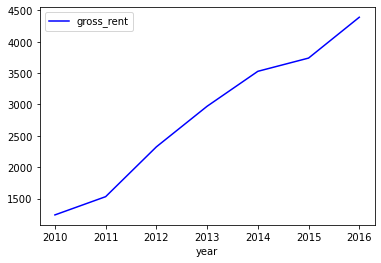

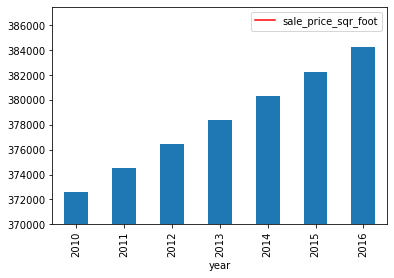

In [94]:
# Create a Title for the Dashboard
#row = pn.Row(scatter_plot, bar_plot)
#row

# Average Price by Neighborhood

welcome = pn.Column(
    '# Real Estate Analysis of San Francisco 2010 to 2016',
    '## Welcome to dashboard',
    neighborhood_map
)

average_cost_sf = pn.Row(
    average_gross_rent,
    average_sales_price
)

average_price_by_neighborhood = pn.Column(
    average_price_by_neighborhood,
    top_most_expensive_neighborhoods,
    most_expensive_neighborhoods_rent_sales
)

# Create a tab layout for the dashboard
tabs = pn.Tabs(
    ("Welcome", welcome),
    ("Housing Per Year in San Francisco",housing_units_per_year),
    ("Parallel Categories", parallel_categories),
    ("Average Cost in San Francisco", average_cost_sf),
    ("Sunburst", sunburst)
)
tabs

# Create the dashboard
# YOUR CODE HERE!

## Serve the Panel Dashboard

In [41]:
# Serve the# dashboard
# YOUR CODE HERE!

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [42]:
#housing_units_per_year()

In [83]:
 average_gross_rent()

KeyError: "None of [Index(['gross_rent'], dtype='object', name='year')] are in the [index]"

In [44]:
# average_sales_price()

In [45]:
# average_price_by_neighborhood()

In [46]:
# top_most_expensive_neighborhoods()

In [47]:
# most_expensive_neighborhoods_rent_sales()

C:\Users\Jay Cao\Anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:78: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



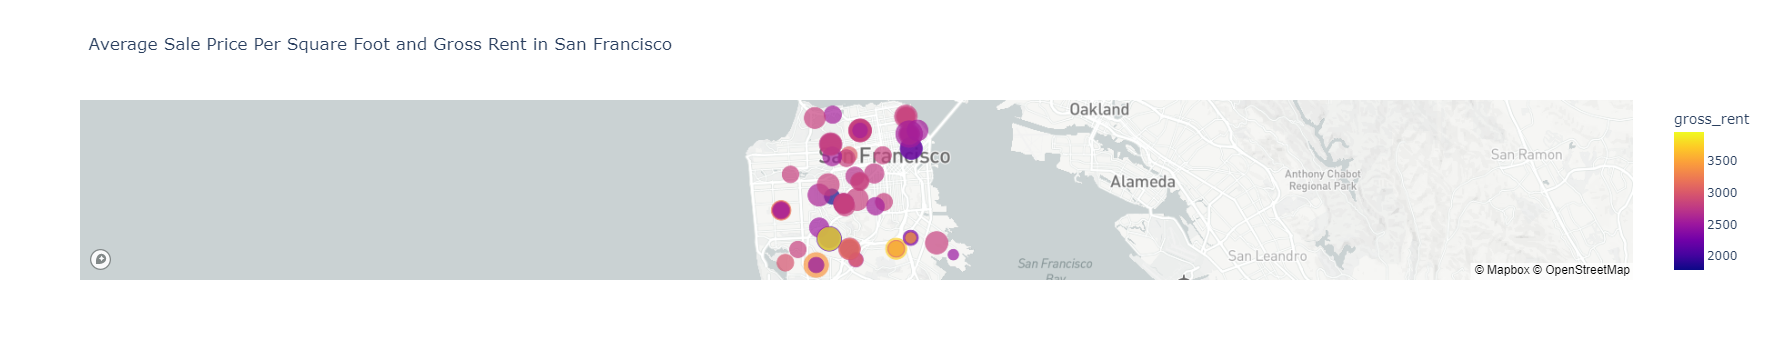

In [60]:
 neighborhood_map()#.show()

In [49]:
# parallel_categories()

In [50]:
 # parallel_coordinates()

In [51]:
# sunburst()